## 🔮 Deep Learning in Practice


<img src="https://i.imgur.com/TEFUEow.png">

<table>
  <tr> <th>torch</th> <th>torch.nn</th> <th>torch.nn.functional</th> <th>torch.optim</th> <th>torch.utils</th> </tr>
  <tr> 
  <td> Wraps all other modules and offers tensor functionality on GPU and automatic differentiation </td> 
  <td> Basic blocks of neural networks (i.e., layers, activations and loss functions) </td> 
  <td> Stateless functional version of (torch.nn) </td> 
  <td> Optimization algorithms and learning rate schedulers</td> 
  <td> reading data, batching, logging, etc. </td> </tr>
</table>


We're done with `torch` and `torch.utils`. Let's have a look at optimizers.

Have covered gradient descent:
$$ θ_t = θ_t -α \frac{∂J(θ)}{∂w} $$

It helped us iteratively minimize the loss function $J$ where it was infeasible to directly set $\frac{∂J}{∂ w}=0$. Have covered many improvements over it:

- Mini-batch Gradient Descent

- Gradient Descent with Momentum → Speed up search in intended directions

- RMS Prop → Slow down search in unintended directions

- ADAM → Combine both for even faster convergence!

$$θ_{t+1} = θ_t - α * (\frac {m_t}{\sqrt{v_t} + ε})$$

where

$$m_t = β₁ * m_{t-1} + (1 - β₁) * \frac{∂J(θ)}{∂w}$$

$$v_t = β₂ * v_{t-1} + (1 - β₂) * (\frac{∂J(θ)}{∂w})^2$$

PyTorch supports all of these optimizers out of the box (as well 10 others or so!) as well as learning rate schedulers to dynamically change the learning rate while training according to the number of epochs.

In PyTorch we use optimizer as follows:
```python
# 1. Construct the optimizer object

optimizer = optim.SomeOptimizer([weights], lr=lr, hyperparams)      # weights have required_grad=True

# 2. Once J.backward() is done (i.e., all ∂J/∂θ are computed)

optimizer.step()                                                    # Performs a single optimization step

# 3. To prevent gradient accumulation the next time we do J.backward(), reset the gradients:

optimizer.zero_grad()                                               # Sets ∂J/∂W to zero
```



Let's see this in action by revisiting our implementation of logistic regression:

In [1]:
import torch
import torch.optim as optim
import numpy as np

#### 1. Define hypothesis f(x;θ)

In [2]:
def f(u_data, weights):                         
    σ = lambda z: 1 / (1 + torch.exp(-z))
    return σ(u_data @ weights)                  # σ(x1w1 + x2w2+...+w0)

#### 2. Define the Loss Function J

In [3]:
# 2. Define loss function
def J(y_pred, y_true):
    ln, ϵ = torch.log, 1e-7                                    # Small value to avoid log(0)
    ŷ, y = y_pred, y_true
    return -torch.mean(y * ln(ŷ + ϵ) + (1 - y) * ln(1 - ŷ + ϵ))

#### 3. Train the model by minimizing J

In [4]:
class LogisticRegression:
    def __init__(self):
        self.weights = None                                 # w0, w1, ..., wn

    def fit(self, x_train, y_train, lr=0.01, num_epochs=100):
        # 0. Handle Numpy arrays
        u_train = torch.tensor(np.c_[np.ones(len(x_train)), x_train], dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)

        # 1. Initialize weights
        n = u_train.shape[1]
        self.weights = torch.zeros((n,), dtype=torch.float32, requires_grad=True)  # w0, w1, w2, ..., wn

        # 2. Initialize optimizer
        optimizer = optim.Adam([self.weights], lr=lr)

        for epoch in range(num_epochs):  
            # 1. Forward pass to define the graph and store needed values
            y_pred = f(u_train, self.weights)
            loss = J(y_pred, y_train)

            # 2. Backward pass to compute derivatives
            loss.backward()

            # 3. Update weights
            optimizer.step()
            
            # 4. Zero the gradients
            optimizer.zero_grad()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    def predict(self, x_val):
        # Handle Numpy arrays
        x_val = torch.tensor(np.c_[np.ones(len(x_val)), x_val], dtype=torch.float32)

        y_pred_probs = f(x_val, self.weights)
        return (y_pred_probs > 0.5).float()  # Convert probabilities to binary classes

Begin training

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Generate synthetic dataset using make_blobs
X, y = make_blobs(n_samples=700, centers=2, n_features=2, cluster_std=3.0, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(x_train, y_train)

Epoch [10/100], Loss: 0.4545
Epoch [20/100], Loss: 0.3284
Epoch [30/100], Loss: 0.2641
Epoch [40/100], Loss: 0.2261
Epoch [50/100], Loss: 0.2029
Epoch [60/100], Loss: 0.1878
Epoch [70/100], Loss: 0.1771
Epoch [80/100], Loss: 0.1691
Epoch [90/100], Loss: 0.1630
Epoch [100/100], Loss: 0.1580


Evaluate performance

In [6]:
# Calculate accuracy
y_pred = lr.predict(x_val)
accuracy = torch.tensor(list(y_pred) == y_val).float().mean()
print(f'Accuracy: {accuracy.item()*100:.2f}%')

Accuracy: 95.00%


#### Learning Rate Schedules

```python
# 1. Construct the scheduler object and pass to it the optimizer:
optimizer = optim.SomeScheduler(optimizer, hyperparams)     

# 2. Every time an epoch passes do:
optimizer.step() 
```

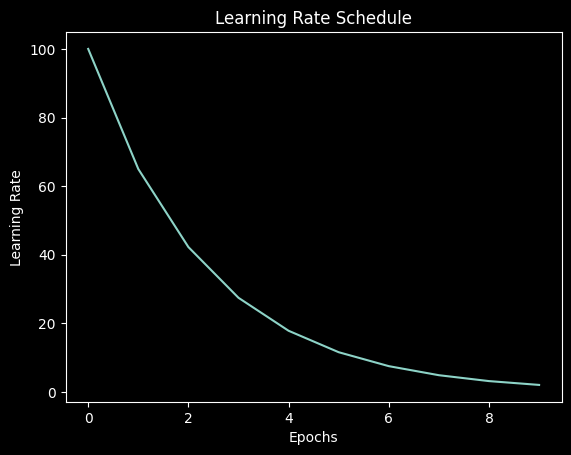

In [7]:
import torch
import matplotlib.pyplot as plt

# 1. Define some optimizer
weights = torch.randn(2, 1, requires_grad=True)
optimizer = torch.optim.SGD([weights], lr=100)

# 2. Let's consider a generic optimizer that multiplies a function by the learning rate
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

lrs = []

for epoch in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])     # access learning rate of weights
    scheduler.step()

plt.style.use('dark_background')
plt.plot(range(10), lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

Cyclic learning rate schedules have been attracting plenty of attention. The sudden increases in learning rates help escape from a bad local minima. See [here](https://link.springer.com/article/10.1007/s10489-021-02199-4/figures/2)

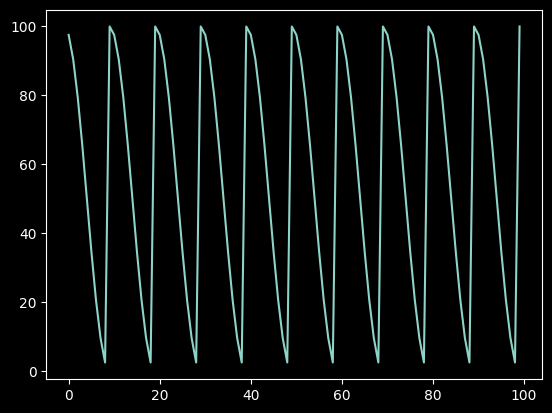

In [8]:
import torch
import matplotlib.pyplot as plt

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001, last_epoch=-1)
lrs = []
for i in range(100):
    scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(lrs)

Now let's move on to `torch.nn`.